In [7]:
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon, ttest_rel

# ---------- paths for Elastic Net only (bulk vs pseudobulk)
BULK_FILE = "voom_bulk_10_fold_30_pcs_tissue_growth.csv"
PSEUDO_FILE = "10_fold_pseudobulk_voom_30_pcs_tissue_growth.csv"

PATHS = {
    "Bulk": f"01_simple_baselines/results/elastic_net/{BULK_FILE}",
    "Pseudobulk": f"01_simple_baselines/results/elastic_net/{PSEUDO_FILE}",
}

def load_results(path, label):
    df = pd.read_csv(path)
    # Normalize column names
    df.rename(columns=lambda c: c.strip().replace("²", "^2"), inplace=True)
    if "r2_mean" not in df.columns and "r2_global" in df.columns:
        df = df.rename(columns={"r2_global":"r2_mean", "rmse":"rmse_mean"})
    needed = {"DRUG_ID","n_samples","r2_mean","rmse_mean",
              "pearson_r","pearson_pval","spearman_r","spearman_pval"}
    missing = sorted(list(needed - set(df.columns)))
    if missing:
        raise ValueError(f"Missing columns in {path}: {missing}")
    df["DataType"] = label
    return df[["DRUG_ID","n_samples","r2_mean","rmse_mean",
               "pearson_r","pearson_pval","spearman_r","spearman_pval","DataType"]]

frames = [load_results(p, m) for m,p in PATHS.items()]
bulk_df = pd.concat(frames, ignore_index=True)
print("✅ combined:", bulk_df.shape)
bulk_df.head()


✅ combined: (1250, 9)


,DRUG_ID,n_samples,r2_mean,rmse_mean,pearson_r,pearson_pval,spearman_r,spearman_pval,DataType
0,133,132,0.042170,1.658243,0.207873,0.016768,0.188408,0.030505,Bulk
1,134,132,0.052034,1.861967,0.230291,0.007896,0.242595,0.005068,Bulk
2,135,131,0.053810,2.538988,0.246203,0.004587,0.269161,0.001879,Bulk
3,136,133,0.016416,1.494454,0.173342,0.046006,0.139557,0.109132,Bulk
4,140,133,0.049421,1.597350,0.222344,0.010103,0.213903,0.013427,Bulk


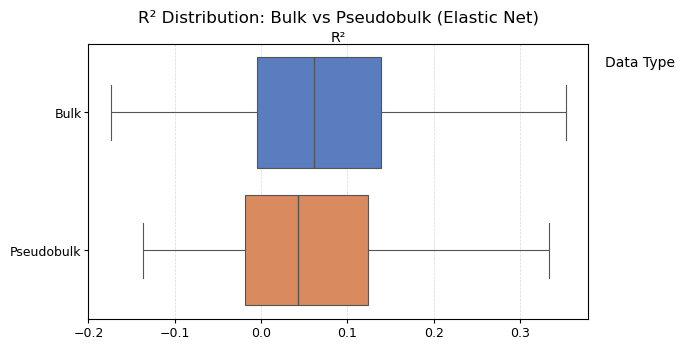

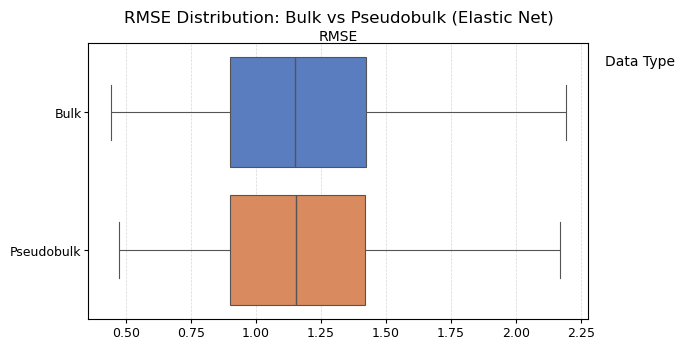

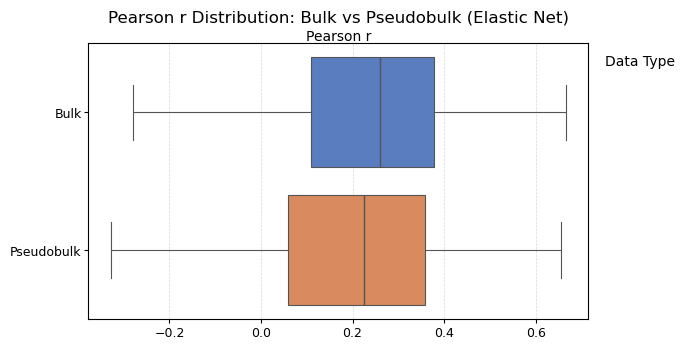

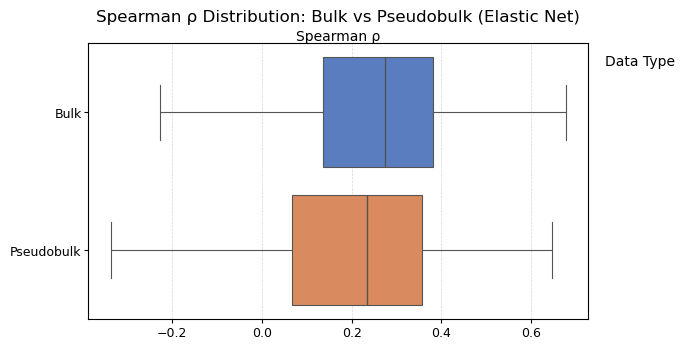

In [8]:
# %%
# boxplots (R², RMSE, Pearson r, Spearman ρ) comparing Bulk vs Pseudobulk
def nice_boxplot(df, x, title):
    fig, ax = plt.subplots(figsize=(7, 3.6))
    sns.boxplot(
        data=df, x=x, y="DataType", hue="DataType",
        palette="muted", showfliers=False, dodge=False, ax=ax,
        boxprops=dict(linewidth=0.8),
        whiskerprops=dict(linewidth=0.8),
        capprops=dict(linewidth=0.8),
        medianprops=dict(linewidth=1.0),
    )
    ax.set_title(title, fontsize=12)
    ax.xaxis.set_label_position('top')
    ax.set_xlabel({"r2_mean":"R²", "rmse_mean":"RMSE",
                   "pearson_r":"Pearson r","spearman_r":"Spearman ρ"}[x],
                   fontsize=10, labelpad=2)
    ax.set_ylabel("")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title="Data Type", frameon=False, loc="upper left",
              bbox_to_anchor=(1.01, 1.0), fontsize=9, title_fontsize=10)
    for sp in ax.spines.values(): sp.set_linewidth(0.8)
    ax.tick_params(axis="both", labelsize=9, width=0.8, length=3, pad=2)
    ax.grid(axis="x", linestyle="--", alpha=0.5, linewidth=0.5)
    plt.tight_layout(); plt.show()

nice_boxplot(bulk_df, "r2_mean",    "R² Distribution: Bulk vs Pseudobulk (Elastic Net)")
nice_boxplot(bulk_df, "rmse_mean",  "RMSE Distribution: Bulk vs Pseudobulk (Elastic Net)")
nice_boxplot(bulk_df, "pearson_r",  "Pearson r Distribution: Bulk vs Pseudobulk (Elastic Net)")
nice_boxplot(bulk_df, "spearman_r", "Spearman ρ Distribution: Bulk vs Pseudobulk (Elastic Net)")


In [9]:
# %% paired tests: Bulk vs Pseudobulk per drug (positive delta = Pseudobulk better)
def paired_tests(df, metric="r2_mean"):
    wide = df.pivot_table(index="DRUG_ID", columns="DataType", values=metric, aggfunc="mean").dropna()
    if wide.empty:
        return None
    x, y = wide["Pseudobulk"], wide["Bulk"]
    if metric in ("r2_mean","pearson_r","spearman_r"):  # higher is better
        d = x - y
    else:  # rmse_mean: lower is better
        d = y - x
    n = len(d)
    return {
        "n": n,
        "delta_mean": d.mean(),
        "delta_median": d.median(),
        "win_rate": (d > 0).mean(),  # fraction where Pseudobulk wins
        "wilcoxon_p": wilcoxon(d, zero_method="pratt").pvalue if n>=5 else np.nan,
        "ttest_p": ttest_rel(x, y, nan_policy="omit").pvalue if n>=5 else np.nan
    }

rows = []
for metric, nice in [("r2_mean","R² (Pseudo - Bulk)"),
                     ("rmse_mean","RMSE (Bulk - Pseudo)"),   # lower is better
                     ("pearson_r","Pearson r (Pseudo - Bulk)"),
                     ("spearman_r","Spearman ρ (Pseudo - Bulk)")]:
    out = paired_tests(bulk_df, metric)
    if out:
        rows.append({"Metric": nice, **out})
paired_summary = pd.DataFrame(rows)
display(paired_summary)


,Metric,n,delta_mean,delta_median,win_rate,wilcoxon_p,ttest_p
0,R² (Pseudo - Bulk),625,-0.013212,-0.013791,0.3904,1.455923e-08,6.301686e-07
1,RMSE (Bulk - Pseudo),625,-0.006236,-0.007999,0.3888,2.208818e-07,5.226444e-04
2,Pearson r (Pseudo - Bulk),625,-0.028550,-0.025488,0.3952,1.310125e-09,6.198076e-08
3,Spearman ρ (Pseudo - Bulk),625,-0.033355,-0.030192,0.3808,2.984954e-11,1.044399e-09


In [10]:
# %% aggregate stats per data type
def agg_stats(df, metric):
    g = df.groupby(["DataType"], as_index=False)[metric].agg(mean="mean", std="std", n="count")
    g["se"] = g["std"] / np.sqrt(g["n"])
    g["ci95"] = 1.96 * g["se"]
    g["metric"] = metric
    return g.rename(columns={"mean":"Mean","std":"Std","n":"N","ci95":"95% CI"})

summary_table = pd.concat([
    agg_stats(bulk_df, "r2_mean"),
    agg_stats(bulk_df, "rmse_mean"),
    agg_stats(bulk_df, "pearson_r"),
    agg_stats(bulk_df, "spearman_r"),
], ignore_index=True)

display(summary_table[["metric","DataType","N","Mean","Std","95% CI"]].round(4))


,metric,DataType,N,Mean,Std,95% CI
0,r2_mean,Bulk,625,0.0776,0.1060,0.0083
1,r2_mean,Pseudobulk,625,0.0644,0.1078,0.0085
2,rmse_mean,Bulk,625,1.1847,0.3787,0.0297
3,rmse_mean,Pseudobulk,625,1.1909,0.3755,0.0294
4,pearson_r,Bulk,625,0.2356,0.2035,0.0160
5,pearson_r,Pseudobulk,625,0.2071,0.2114,0.0166
6,spearman_r,Bulk,625,0.2395,0.2058,0.0161
7,spearman_r,Pseudobulk,625,0.2061,0.2145,0.0168


In [11]:
# %% proportion of significant correlations (p < 0.05) per data type
sig_rates = (
    bulk_df.assign(sig_pearson = bulk_df["pearson_pval"] < 0.05,
                   sig_spearman = bulk_df["spearman_pval"] < 0.05)
            .groupby("DataType")
            .agg(pearson_rate=("sig_pearson","mean"),
                 spearman_rate=("sig_spearman","mean"),
                 N=("sig_pearson","count"))
            .reset_index()
)
sig_rates["pearson_rate"] = (100*sig_rates["pearson_rate"]).round(1)
sig_rates["spearman_rate"] = (100*sig_rates["spearman_rate"]).round(1)
sig_rates.rename(columns={"pearson_rate":"% Pearson p<0.05",
                          "spearman_rate":"% Spearman p<0.05"}, inplace=True)
display(sig_rates)


,DataType,% Pearson p<0.05,% Spearman p<0.05,N
0,Bulk,72.2,74.6,625
1,Pseudobulk,63.7,70.6,625


In [12]:
# %% per-drug winners (not applicable with only Elastic Net)
summary_r2 = pd.DataFrame([{"Metric":"r2_mean","RF wins":np.nan,"EN wins":np.nan,"Ties":np.nan,
                            "RF win rate (no ties)":np.nan,"Sign test p":np.nan}])
summary_rmse = pd.DataFrame([{"Metric":"rmse_mean","RF wins":np.nan,"EN wins":np.nan,"Ties":np.nan,
                              "RF win rate (no ties)":np.nan,"Sign test p":np.nan}])
summary_r = pd.DataFrame([{"Metric":"pearson_r","RF wins":np.nan,"EN wins":np.nan,"Ties":np.nan,
                           "RF win rate (no ties)":np.nan,"Sign test p":np.nan}])
summary_spearman = pd.DataFrame([{"Metric":"spearman_r","RF wins":np.nan,"EN wins":np.nan,"Ties":np.nan,
                                  "RF win rate (no ties)":np.nan,"Sign test p":np.nan}])

display(summary_r2)
display(summary_rmse)
display(summary_r)
display(summary_spearman)


,Metric,RF wins,EN wins,Ties,RF win rate (no ties),Sign test p
0,r2_mean,NaN,NaN,NaN,NaN,NaN


,Metric,RF wins,EN wins,Ties,RF win rate (no ties),Sign test p
0,rmse_mean,NaN,NaN,NaN,NaN,NaN


,Metric,RF wins,EN wins,Ties,RF win rate (no ties),Sign test p
0,pearson_r,NaN,NaN,NaN,NaN,NaN


,Metric,RF wins,EN wins,Ties,RF win rate (no ties),Sign test p
0,spearman_r,NaN,NaN,NaN,NaN,NaN
